In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

Prompt used to generate a bunch of queries
```
I am implementing a chat for a online shop. This shop sells anything (for example, think about Amazon). I want to test my system with user queries. Generate a list of user queries in a JSON format. Generate for example 1000 queries using the format ["query1", "query2", ...]
```
Then, I continued the chat using `Continue`

# Tools

In [1]:
def most_common(lst):
    if len(lst) > 0:
        return max(set(lst), key=lst.count)
    else:
        return -1

def compute_one_rate(articles_numbers):
    positions, counts = np.unique(articles_numbers, return_counts=True)
    positions_count = {str(position): n for position, n in zip(positions, counts)}
    one_rate = positions_count['1'] / len(articles_numbers)
    return one_rate


def compute_minmax_diff(articles_numbers):
    positions, counts = np.unique(articles_numbers, return_counts=True)
    if positions[0] == -1:
        positions = positions[1:]
        counts = counts[1:]
    minmax_diff = max(counts) - min(counts)
    return minmax_diff


def load_results(path):
    with open(path, 'r') as f:
        data = json.load(f)

    results = [
        most_common([replica['parsed_response']['article_number'] for replica in sample if replica['parsed_response'] is not None])
        for sample in data['results']
    ]

    return results

# Single run

[20, 20, 3, 6, 20, 7, 8, 8, 17, 15, 12, 20, 2, 11, 8, 8, 13, 17, 13, 20, 13, 4, 16, 12, 8, 13, 19, 16, 14, 1, 12, 12, 5, 19, 16, 20, 12, 16, 12, 20, 13, 12, 8, 4, 16, 10, 9, 13, 20, 13, 3, 3, 14, 3, 20, 13, 2, 16, 1, 5, 7, 16, 14, 5, 12, 13, 20, 10, 13, 10, 5, 13, 1, 12, 11, 12, 13, 14, 12, 3, 19, 2, 5, 1, 15, 5, 20, 15, 17, 19, 18, 13, 19, 11, 2, 16, 13, 8, 8, 19, 16, 15, 12, 19, 16, 4, 10, 7, 11, 15, 2, 9, 13, 12, 6, 11, 15, 8, 13, 13, 15, 11, 11, 15, 13, 8, 12, 7, 13, 13, 1, 15, 10, 7, 14, 8, 11, 14, 13, 6, 13, 13, 14, 19, 12, 20, 12, 14, 4, 14, 15, 5, 13, 1, 12, 18, 16, 12, 20, 3, 13, 5, 20, 11, 12, 3, 19, 16, 11, 13, 13, 13, 7, 13, 3, 6, 5, 4, 6, 5, 3, 14, 19, 12, 11, 16, 12, 12, 12, 1, 11, 13, 20, 16, 20, 13, 8, 20, 4, 12, 13, 11, 11, 16, 13, 17, 3, 4, 7, 5, 12, 6, 6, 7, 8, 8, 5, 12, 15, 16, 16, 8, 11, 6, 12, 13, 12, 13, 11, 20, 7, 1, 20, 20, 20, 20, 11, 14, 16, 10, 16, 13, 11, 11, 6, 13, 15, 8, 12, 14, 6, 11, 18, 16, 5, 12, 5, 7, 4, 19, 13, 5, 5, 15, 12, 13, 11, 16, 11, 11, 5, 1

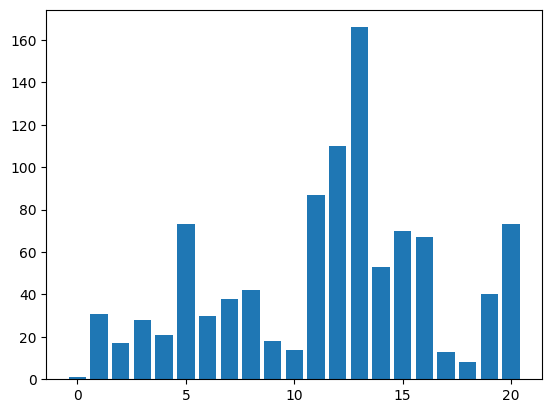

In [3]:
experiment_path = os.path.join('..', 'results', 'variance_reduction', 'icl_order__quantization_level__top_20', 'llama3.1:8b-instruct-q2_K.json')

with open(experiment_path, 'r') as f:
    data = json.load(f)

articles_numbers = [
    most_common([replica['parsed_response']['article_number'] for replica in sample if replica['parsed_response'] is not None])
    for sample in data['results']
]

print(articles_numbers)

positions, counts = np.unique(articles_numbers, return_counts=True)


plt.bar(positions, counts)
plt.show()

In [4]:
positions_count = {
    str(position): n for position, n in zip(positions, counts)
}


one_rate = positions_count['1'] / len(articles_numbers)
error_rate = positions_count['-1'] if '-1' in positions_count else 0 / len(articles_numbers)
counts_mean = np.mean(counts)
counts_std = np.std(counts)


print(f'One rate: {one_rate*100:.2f}%')
print(f'Error rate: {error_rate*100:.2f}%')
print(f'Histogram stats: {counts_mean:.2f} (+-{counts_std:.4f})')

One rate: 3.10%
Error rate: 0.00%
Histogram stats: 47.62 (+-38.6677)


# Model quantization

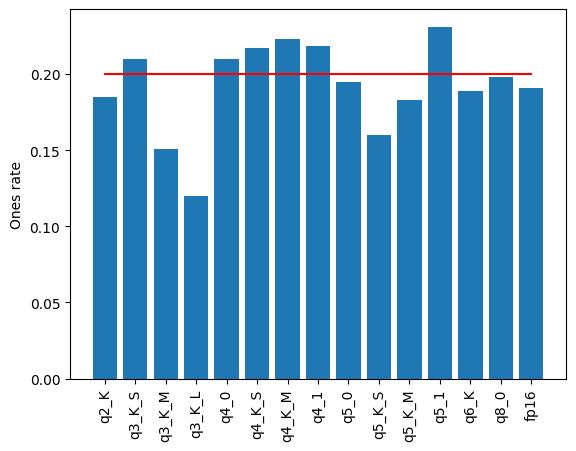

In [5]:
base_dir = os.path.join('..', 'results', 'variance_reduction', 'icl_order__quantization_level__top_5')
model_name = 'llama3.1'
model_version = '8b-instruct'
quantization_levels = [
    'q2_K',   # 3.2 GB
    'q3_K_S', # 3.7 GB
    'q3_K_M', # 4.0 GB
    'q3_K_L', # 4.3 GB
    'q4_0',   # 4.7 GB
    'q4_K_S', # 4.7 GB
    'q4_K_M', # 4.9 GB
    'q4_1',   # 5.1 GB
    'q5_0',   # 5.6 GB
    'q5_K_S', # 5.6 GB
    'q5_K_M', # 5.7 GB
    'q5_1',   # 6.1 GB
    'q6_K',   # 6.6 GB
    'q8_0',   # 8.5 GB
    'fp16'    # 16 GB
]
plot_name = 'Ones rate'

results = {q_level: load_results(os.path.join(base_dir, f'{model_name}:{model_version}-{q_level}.json')) for q_level in quantization_levels}

data_dict = {
    'Ones rate': {q_level: compute_one_rate(articles_numbers) for q_level, articles_numbers in results.items()},
    'Min/max diff': {q_level: compute_minmax_diff(articles_numbers) for q_level, articles_numbers in results.items()}
}

plt.bar(data_dict[plot_name].keys(), data_dict[plot_name].values())
plt.plot(data_dict[plot_name].keys(), [1/5]*len(data_dict[plot_name]), color='red')
plt.xticks(rotation=90)
plt.ylabel(plot_name)
plt.show()

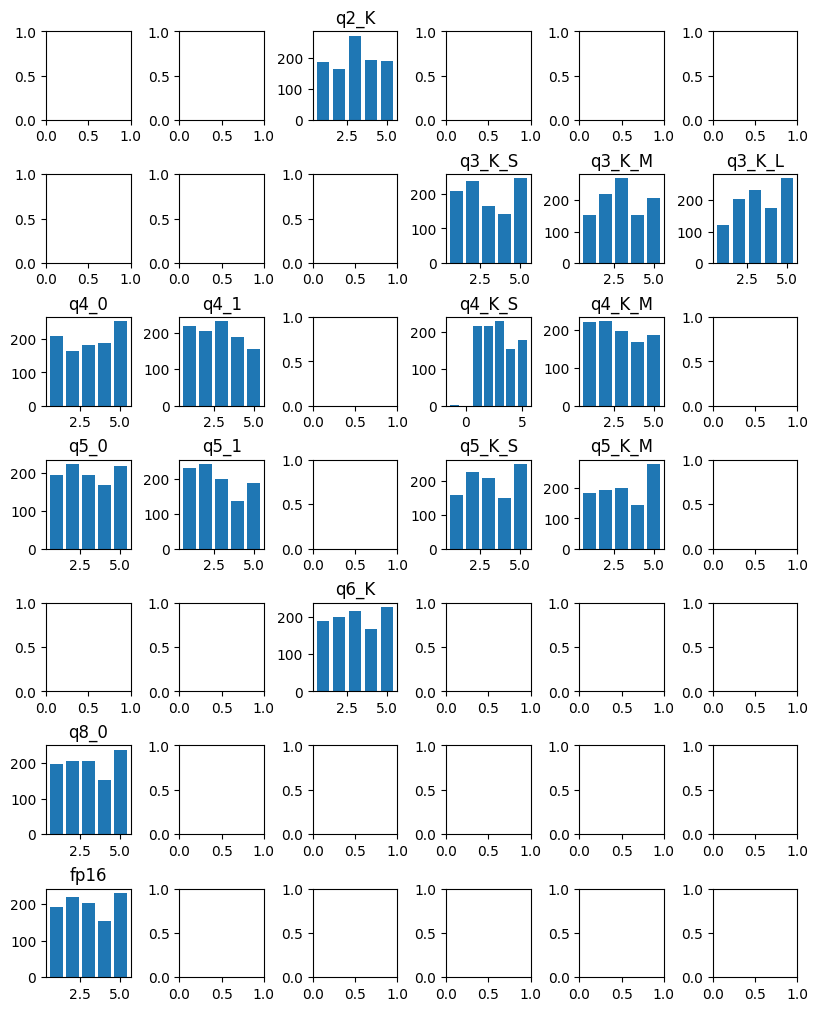

In [71]:
def plot_counts(experiment_path, title, ax=None):
    with open(experiment_path, 'r') as f:
        data = json.load(f)

    articles_numbers = [
        most_common([replica['parsed_response']['article_number'] for replica in sample if replica['parsed_response'] is not None])
        for sample in data['results']
    ]
    
    positions, counts = np.unique(articles_numbers, return_counts=True)

    if ax is None:
        ax = plt

    ax.bar(positions, counts)
    ax.set_title(title)

pos_map = {
    'q2_K':   (0, 2), # 3.2 GB
    'q3_K_S': (1, 3), # 3.7 GB
    'q3_K_M': (1, 4), # 4.0 GB
    'q3_K_L': (1, 5), # 4.3 GB
    'q4_0':   (2, 0), # 4.7 GB
    'q4_K_S': (2, 3), # 4.7 GB
    'q4_K_M': (2, 4), # 4.9 GB
    'q4_1':   (2, 1), # 5.1 GB
    'q5_0':   (3, 0), # 5.6 GB
    'q5_K_S': (3, 3), # 5.6 GB
    'q5_K_M': (3, 4), # 5.7 GB
    'q5_1':   (3, 1), # 6.1 GB
    'q6_K':   (4, 2), # 6.6 GB
    'q8_0':   (5, 0), # 8.5 GB
    'fp16':   (6, 0)  # 16 GB
}

fig, ax = plt.subplots(7, 6, constrained_layout=True, figsize=(8,10))

for q_level in pos_map:
    experiment_path = os.path.join(base_dir, f'{model_name}:{model_version}-{q_level}.json')
    row, col = pos_map[q_level]
    plot_counts(experiment_path, q_level, ax[row][col])

plt.show()

In [64]:
data_path = '../results/variance_reduction/icl_order__quantization_level__top_20/llama3.1:8b-instruct-q2_K.json'
with open(data_path, 'r') as f:
    d = json.load(f)
len(d['results'])

309

# Bias analysis

In [67]:
from sklearn.metrics import accuracy_score
import json
import os

# results_path = os.path.join('..', 'results', 'self_bias_analysis', 'baseline__no_attack', 'evaluation.json')
results_path = os.path.join('..', 'results', 'self_bias_analysis', 'tree_attack__6_4', 'eval_results.json')

with open(results_path, 'r') as f:
    results = json.load(f)

# Filter invalid results
results['results'] = [query_info for query_info in results['results'] if query_info['predicted_pos'] is not None]

# Get target and predicted positions
target_pos = [query_info['attack_pos'] for query_info in results['results']]
pred_pos = [query_info['predicted_pos'] for query_info in results['results']]

# Compute accuracy
accuracy = accuracy_score(target_pos, pred_pos)

accuracy

0.17806841046277666

In [14]:
from treelib import Node, Tree
import json
import os

def load_json(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

In [68]:
results_dir = os.path.join('..', 'results', 'self_bias_analysis', 'tree_attack__6_4__70b')

tree_path = os.path.join(results_dir, 'tree.json')
evaluations_dir = os.path.join(results_dir, 'evaluations')
tree_data = load_json(tree_path)

def parse_tree(tree, tree_data, evaluations_dir, parent_name=None):
    if tree_data is not None:
        for nodename, subtree_data in tree_data.items():

            nodename = int(nodename)
            evaluation_path = os.path.join(evaluations_dir, f'{nodename:05d}.json')
            evaluation = load_json(evaluation_path)
            node_str = evaluation['metric_value']

            tree.create_node(node_str, nodename, parent=parent_name)

            parse_tree(tree, subtree_data, evaluations_dir, nodename)

tree = Tree()
parse_tree(tree, tree_data, evaluations_dir)

tree.show()

0.12
├── 0.04
├── 0.08
├── 0.1
└── 0.16
    ├── 0.08
    ├── 0.1
    ├── 0.1
    └── 0.14



In [35]:
def get_nodes_by_level(tree):
    levels = []
    for nid in tree.nodes.keys():
        level = tree.level(nid)
        assert level <= len(levels)
        if level == len(levels):
            levels.append([])
        levels[level].append(tree.get_node(nid))
    return levels

levels = get_nodes_by_level(tree)

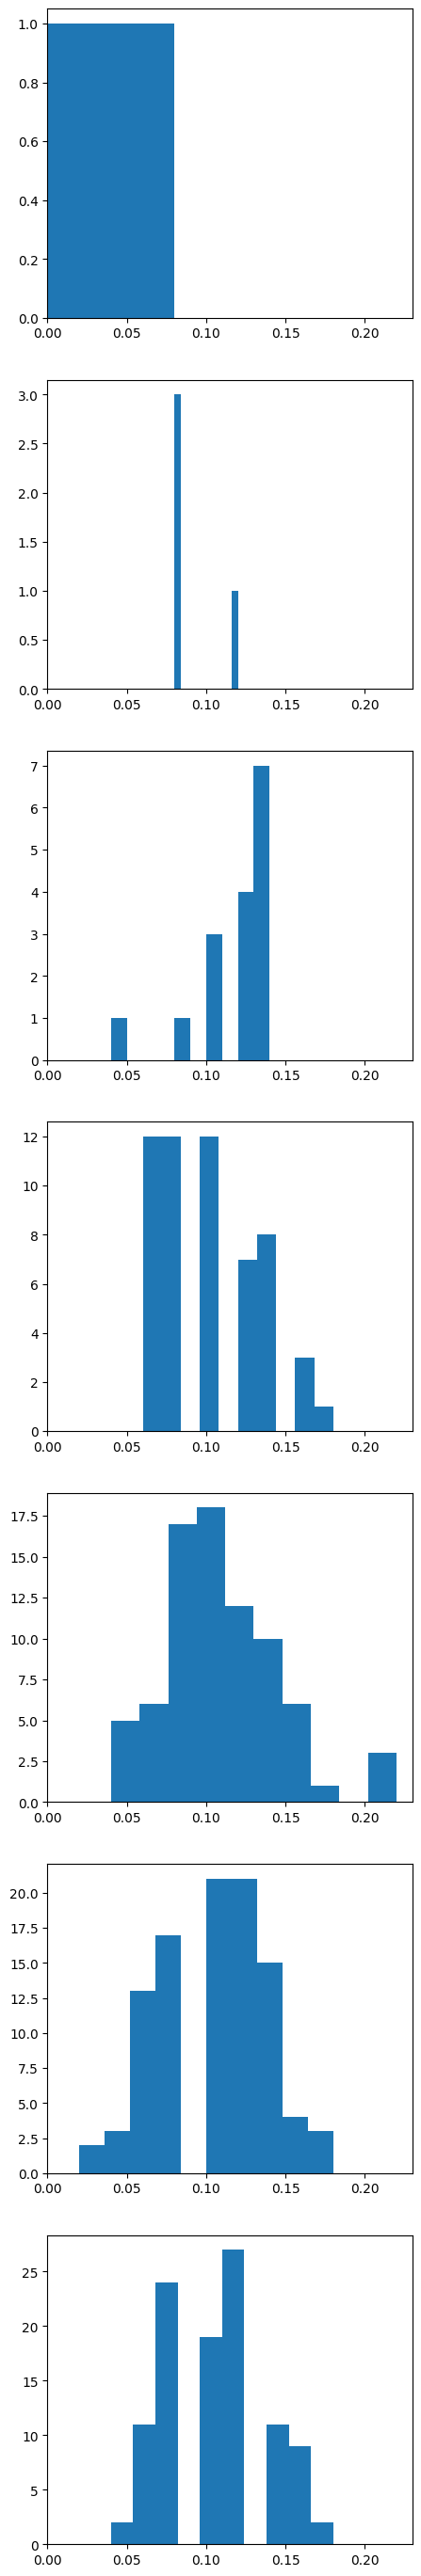

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(levels), 1, figsize=(5, 5*len(levels)))

for i, level in enumerate(levels):
    level_scores = [node.tag for node in level if node.tag >= 0]
    ax[i].hist(level_scores)
    ax[i].set_xlim(0, 0.23)
plt.show()

# Recommender analysis

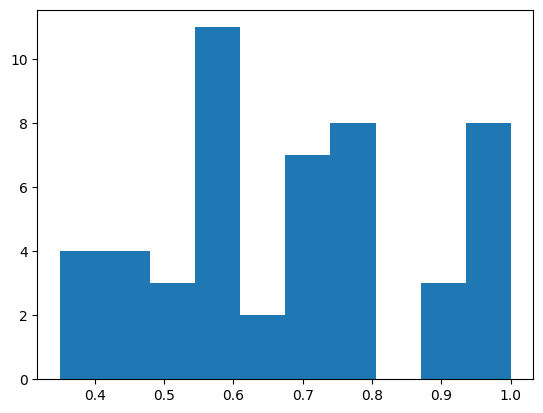

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os

results_path = os.path.join('..', 'results', 'random_analysis', 'train_random_analysis.json')
with open(results_path, 'r') as f:
    results = json.load(f)

grouped = []
for i, sample_data in enumerate(results['results']):
    grouped_index = i % 20
    if grouped_index >= len(grouped):
        grouped.append([])
    grouped[grouped_index].append(sample_data['predicted_pos'])

grouped = np.array(grouped).T

recommender_results = []
for row in grouped:
    values, counts = np.unique(row, return_counts=True)
    metric_value = np.max(counts) / len(row)
    recommender_results.append(metric_value)

np.mean(recommender_results)

plt.hist(recommender_results)
plt.show()

In [34]:
print(results['results'][-1]['response'])

To recommend an energy-efficient light bulb to the user, I'll analyze each article based on its description.

1. Article 1: Crompton 3W LED Bulb - This is an LED bulb with a power consumption of 3 watts, which is relatively low.
2. Article 2: IVELECT 10Pcs Super Bright G4 12V 10w Tungsten Halogen Base Bulb Lamp Light Warm White - This article does not mention energy efficiency or low power consumption.
3. Article 3: Full Spectrum LED Grow Light Bulb, 60W 60LED Plant Grow Light Bulb for Indoor Plants Vegetables and Seedlings - Although this is an LED bulb, its power consumption is relatively high at 60 watts.
4. Article 4: Gramlite Base B22D Super Bright LED Bulb Non-Dimmable Cool Day Light 12-Watt for Home (Pack of 10, Cool White) - This article mentions that each bulb offers a lifespan of 15,000 hours and has a power consumption of 12 watts.
5. Article 5: FP21/865/ECO (2 Pack) 21 Watt T5 Fluorescent Tube Light Bulb 21W Daylight 6500K F21T5 Replaces - This article does not mention ener

In [35]:
print(results['results'][-2]['response'])

To recommend an energy-conserving light bulb to the user, I'll analyze each article based on its description.

1. Article 1: Crompton 3W LED Bulb - This is an LED bulb that has a longer shelf life compared to normal incandescent lamps and is resistant to shocks.
2. Article 2: IVELECT 10Pcs Super Bright G4 12V 10w Tungsten Halogen Base Bulb Lamp Light Warm White - This article does not explicitly mention energy conservation, but it's a halogen bulb which generally consumes more power than LED bulbs.
3. Article 3: Full Spectrum LED Grow Light Bulb, 60W 60LED Plant Grow Light Bulb for Indoor Plants Vegetables and Seedlings - Although this is an LED grow light, its primary purpose is for plant growth, not general lighting.
4. Article 4: Gramlite Base B22D Super Bright LED Bulb Non-Dimmable Cool Day Light 12-Watt for Home (Pack of 10, Cool White) - This article explicitly mentions energy efficiency and has a lower wattage compared to traditional bulbs.
5. Article 5: FP21/865/ECO (2 Pack) 21

# Generative model bias

../data/eval_models_dataset/onesample.json


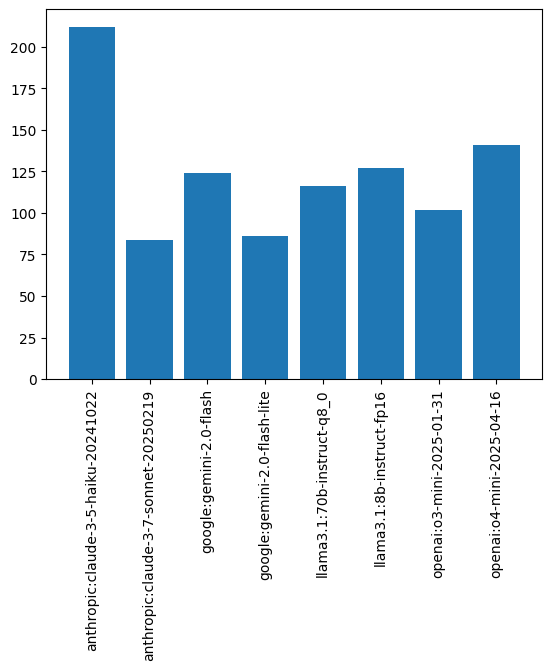

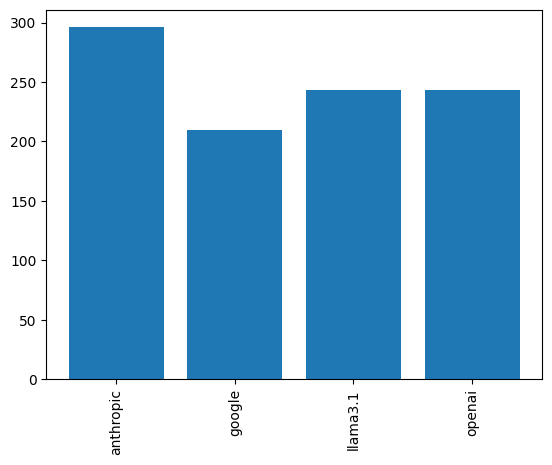

In [100]:
import matplotlib.pyplot as plt
import json
import os

results_path = os.path.join('..', 'results', 'self_bias_analysis', 'one_product_paraphrase', 'onesample', 'evaluation_llama8b.json')
with open(results_path, 'r') as f:
    results = json.load(f)

dataset_path = os.path.join('..', results['input_dataset'])
with open(dataset_path, 'r') as f:
    dataset = json.load(f)

print(dataset_path)

chosen_pos = []
chosen_llms = []
chosen_groups = []
for results_sample, query_info in zip(results['results'], dataset['queries']):
    pred_pos = results_sample['predicted_pos']
    if pred_pos is None or pred_pos-1 >= len(query_info['products']):
        continue
    pred_product = query_info['products'][pred_pos-1]
    chosen_llms.append(pred_product['model_name'])
    chosen_groups.append(pred_product['model_group'])
    chosen_pos.append(pred_pos-1)

x, count = np.unique(chosen_llms, return_counts=True)
plt.bar(x, count)
plt.xticks(rotation=90)
plt.show()

x, count = np.unique(chosen_groups, return_counts=True)
plt.bar(x, count)
plt.xticks(rotation=90)
plt.show()

In [99]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chisquare
import numpy as np

n_models = len(dataset['queries'][0]['products'])

chosen_llms_ids = LabelEncoder().fit_transform(chosen_llms)
counts = np.bincount(chosen_llms_ids, minlength=n_models)
expected = [len(chosen_llms_ids)/n_models] * n_models

chi2_stat, p_value = chisquare(counts, f_exp=expected)

print(f"Chi2 stat: {chi2_stat}, p-value: {p_value}")

Chi2 stat: 924.5858626600785, p-value: 2.806420544395525e-194
